#### iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개 feature 사용
- 구현프레임워크 : Pytorch

- [1] 모듈 로딩 및 데이터 준비

In [8]:
# 모듈로딩
import torch                                    # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn                           # 인공신경망 관련 모듈
import torch.nn.functional as F                 # 손실, 거리 등 함수 관련 모듈
import torch.optim as optimizer                 # 최적화 기법 관련 모듈
from torchmetrics.regression import R2Score     # 성능지표 관련 모듈    <- 추가 설치
from torchinfo import summary                   # 모델 정보 관련 모듈   <- 추가설치

import pandas as pd                             # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split


In [9]:
# 모델의 가중치 및 절편 값 고정 설정
torch.manual_seed(1)

# 저장 및 실행 위치 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE  => {DEVICE}')

DEVICE  => cpu


In [10]:
torch.manual_seed(1)

In [11]:
# 데이터 로딩 : CSV => DataFrame
DATA_FILE=r'C:\Users\KDP-27\Desktop\KDT6\MachineLearning\data\boston.csv'

bostonDF=pd.read_csv(DATA_FILE)
bostonDF.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


[2] 모델 준비
- 학습 방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 >> 선형모델 ==> nn.linear

In [98]:
# [ 모델 설계 ]
# 입력층에 입력값/피쳐 => sepal.length, sepal.width, petal.length 3개
# 출력층의 출력값/타겟 => petal.width 1개
# 입력층 : 입력 피쳐3, 출력 입력층에 존재하는 퍼셉트론 개수 10, AF ReLU
#                       ↓
#              ——————————
#              ↓ ReLU    
# 은닉층 : 입력 10, 출력 입력층에 존재하는 퍼셉트론 개수 5, AF ReLU (이전 층의 출력 값이 입력값으로 들어옴)
#                   ↓
#           —————————
#           ↓ ReLU   
# 출력층 : 입력 5, 출력 타겟/라벨 개수 1, AF - None         (이전 층의 출력 값이 입력값으로 들어옴)  

model=nn.Sequential(nn.Linear(13,10),
                    nn.ReLU(),
                    nn.Linear(10,10),
                    nn.ReLU(),
                    nn.Linear(10,10),
                    nn.ReLU(),
                    nn.Linear(10,10),
                    nn.ReLU(),
                    nn.Linear(10,5),
                    nn.ReLU(),
                    nn.Linear(5,1))

In [99]:
# 모델 구조 확인
print(model)

summary(model, input_size=(200000,13))

Sequential(
  (0): Linear(in_features=13, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): ReLU()
  (8): Linear(in_features=10, out_features=5, bias=True)
  (9): ReLU()
  (10): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [200000, 1]               --
├─Linear: 1-1                            [200000, 10]              140
├─ReLU: 1-2                              [200000, 10]              --
├─Linear: 1-3                            [200000, 10]              110
├─ReLU: 1-4                              [200000, 10]              --
├─Linear: 1-5                            [200000, 10]              110
├─ReLU: 1-6                              [200000, 10]              --
├─Linear: 1-7                            [200000, 10]              110
├─ReLU: 1-8                              [200000, 10]              --
├─Linear: 1-9                            [200000, 5]               55
├─ReLU: 1-10                             [200000, 5]               --
├─Linear: 1-11                           [200000, 1]               6
Total params: 531
Trainable params: 531
Non-trainable params: 0
Total mult-adds (M

In [100]:
# 가중치와 절편 확인

for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[0.weight] Parameter containing:
tensor([[ 0.1780, -0.1285,  0.0429, -0.1595,  0.0745, -0.1768,  0.0597, -0.0763,
         -0.0409,  0.0580, -0.2097, -0.2113, -0.1948],
        [-0.2211,  0.1276,  0.0689, -0.2364,  0.0493,  0.2694, -0.1352,  0.1358,
          0.0149,  0.2598,  0.0245, -0.1348, -0.2185],
        [-0.2469, -0.2676, -0.0836, -0.2113, -0.0674, -0.0110, -0.0208, -0.2380,
         -0.1869, -0.1535, -0.0301,  0.1112, -0.1882],
        [ 0.2591, -0.1207, -0.0286, -0.1386, -0.0464,  0.2057,  0.1134,  0.0312,
          0.1492,  0.1569,  0.0619,  0.0861,  0.1796],
        [-0.1299,  0.2180, -0.0170, -0.1642, -0.1179,  0.1195,  0.1766, -0.0773,
         -0.2668, -0.1582, -0.0247, -0.2348,  0.2139],
        [ 0.0285, -0.1236,  0.1854,  0.1837,  0.1985, -0.0035, -0.2389,  0.1384,
         -0.1514,  0.1592,  0.0156, -0.1411,  0.1839],
        [-0.1573, -0.2208, -0.1510,  0.2528, -0.2135,  0.1229,  0.2232, -0.1290,
         -0.1290,  0.0769, -0.1473, -0.0566, -0.1655],
        [ 0.175

[3] 최적화 인스턴스 준비

In [101]:
### 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(),lr=0.1)

[4] 학습 ==> 개발자가 구현

- [4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행 하거나 또는 학습 전 진행

In [102]:
# 피쳐와 타겟 분리
featureDF=bostonDF[bostonDF.columns[:-1]]
targetDF=bostonDF[['MEDV']]

print(featureDF.shape, targetDF.shape)

(506, 13) (506, 1)


In [103]:
# Train & Test 분할
X_train, X_test, y_train, y_test = train_test_split(featureDF,targetDF,
                                                    test_size=0.2,
                                                    random_state=5)

# Train & valid
X_train, X_val, y_train, y_val=train_test_split(X_train,y_train,
                                                test_size=0.2, random_state=5)

print(f'[FEATURE] TRAIN { X_train.shape}, TEST {X_test.shape}, VAL {X_val.shape}')
print(f'[TARGET] TRAIN {y_train.shape}, TEST {y_test.shape}, VAL {y_val.shape}')



[FEATURE] TRAIN (323, 13), TEST (102, 13), VAL (81, 13)
[TARGET] TRAIN (323, 1), TEST (102, 1), VAL (81, 1)


- [4-2] 학습 진행 
    * 학습 횟수 결정 ==> 에포크 설정
    * 배치크기 결정
    * 배치개수 계산

In [104]:
EPOCH=100            # 처음부터 끝까지 공부하는 횟수
BATCH_SIZE=12                        # 1에포크에서 한 번 학습할 분량 크기
BATCH_CNT=X_train.shape[0]//BATCH_SIZE      # 1에포크에서 총 학습 횟수이면서 가중치 업데이트 횟수

print(f'EPOCH:{EPOCH}, BATCH_SIZE:{BATCH_SIZE},BATCH_CNT:{BATCH_CNT}')

EPOCH:100, BATCH_SIZE:12,BATCH_CNT:26


In [105]:
## 테스트/검증 함수 
# ==> 가중치, 절편 업데이트 X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행

def testing(testDF,targetDF,kind='val'):

    #Tensor화
    testTS=torch.FloatTensor(testDF.values).to(DEVICE)
    targetTS=torch.FloatTensor(targetDF.values).to(DEVICE)

    with torch.no_grad(): #가중치 및 절편 업데이트 진행 X
        # (1) 학습진행 - forward
        pre_y=model(testTS)

        # (2) 오차 계산 - 손실함수
        loss=F.mse_loss(pre_y, targetTS)
        
        # (3)성능평가 - R2
        r2=R2Score()(pre_y,targetTS)

        # (4) 학습결과 출력 및 저장
        print(f'{kind} LOSS : {loss}, R2:{r2}')

    return loss, r2

In [106]:
# 모델 학습 함수
def training(featureTS,targetTS,valTS, valTargetTS):
    
    loss_history=[[],[]]    #[[train],[val]]
    r2_history=[[],[]]

    for epoch in range(EPOCH):
        # 배치 손실 저장 변수
        bs_loss,bs_r2=0,0

        # 배치크기 만큼 학습 진행
        for i in range(BATCH_CNT):        # (1) 학습진행 - forward
            start= i* BATCH_SIZE
            end=start+BATCH_SIZE
            # print(start, end)

            
            # BS크기 만큼만 데이터 추출해서 Tensor화 진행
            BSX_train=torch.FloatTensor(X_train[start:end].values).to(DEVICE)
            BSy_train=torch.FloatTensor(y_train[start:end].values).to(DEVICE)

            # print(BSX_train.shape, BSX_train.device, BSX_train.dtype)
            # print(BSy_train.shape, BSy_train.device, BSy_train.dtype)


            # (1) 학습진행 -forward
            pre_y=model(BSX_train)
            print(f'pre_y.shape:{pre_y.shape}')

            # (2) 오차 계산 - 손실함수
            loss=F.mse_loss(pre_y, BSy_train)
            bs_loss+=loss.item()
            bs_r2+=R2Score()(pre_y,BSy_train).item()


            # (3) 최적화 - 가중치, 절편 업데이트 backward
            adam_optim.zero_grad()
            loss.backward()
            adam_optim.step()
        
        # (4) 모델이 제대로 만들어 지는지 검사
        val_loss, val_r2=testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())
        r2_history[1].append(val_r2.item())


        #에포크 단위 손실과 성능지표
        loss_history[0].append(bs_loss/BATCH_CNT)
        r2_history[0].append(bs_r2/BATCH_CNT)


        
        # (5) 학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] \n -TRAIN LOSS : {loss_history[0][-1]}, R2: {r2_history[0][-1]}')
        print(f' -VALID LOSS : {loss_history[1][-1]}, R2: {r2_history[1][-1]}')
    
    return loss_history, r2_history

In [107]:
# 모델 학습 진행
loss_list,r2_list=training(X_train,y_train,X_val,y_val)
loss_list

pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
val LOSS : 103.39185333251953, R2:-0.19097959995269775
[0/100] 
 -TRAIN LOSS : 229.91378395374005, R2: -1.8720563099934504
 -VALID LOSS : 103.39185333251953, R2: -0.190

[[229.91378395374005,
  87.59725959484393,
  83.05668588785025,
  81.6910676589379,
  63.375140520242546,
  55.72413422511174,
  51.124502475445084,
  59.86726735188411,
  53.485382520235504,
  44.43328123826247,
  36.001702748812164,
  48.3853791310237,
  41.89619493484497,
  39.6888605264517,
  46.05829121516301,
  56.368032638843246,
  47.895413178663986,
  37.788265008192795,
  37.78312651927654,
  38.17231224133418,
  38.23376552875225,
  39.74264724438007,
  39.176723406865044,
  36.81746218754695,
  38.19342411481417,
  40.40584597220788,
  29.858435227320744,
  33.53125066023607,
  37.58245361768282,
  38.39348162137545,
  32.40602502456078,
  45.95686762149517,
  29.73901049907391,
  34.98071901614849,
  61.113793703225944,
  49.419591646928055,
  45.29878656680767,
  44.17722514959482,
  43.15036018078144,
  34.925637868734505,
  29.70853042602539,
  31.378707904082077,
  34.95146824763371,
  36.12734237084022,
  31.39659881591797,
  30.72977983034574,
  36.16833547445444,
  

In [108]:
loss_list[0]

[229.91378395374005,
 87.59725959484393,
 83.05668588785025,
 81.6910676589379,
 63.375140520242546,
 55.72413422511174,
 51.124502475445084,
 59.86726735188411,
 53.485382520235504,
 44.43328123826247,
 36.001702748812164,
 48.3853791310237,
 41.89619493484497,
 39.6888605264517,
 46.05829121516301,
 56.368032638843246,
 47.895413178663986,
 37.788265008192795,
 37.78312651927654,
 38.17231224133418,
 38.23376552875225,
 39.74264724438007,
 39.176723406865044,
 36.81746218754695,
 38.19342411481417,
 40.40584597220788,
 29.858435227320744,
 33.53125066023607,
 37.58245361768282,
 38.39348162137545,
 32.40602502456078,
 45.95686762149517,
 29.73901049907391,
 34.98071901614849,
 61.113793703225944,
 49.419591646928055,
 45.29878656680767,
 44.17722514959482,
 43.15036018078144,
 34.925637868734505,
 29.70853042602539,
 31.378707904082077,
 34.95146824763371,
 36.12734237084022,
 31.39659881591797,
 30.72977983034574,
 36.16833547445444,
 32.64976336405827,
 42.54734820585985,
 49.18352

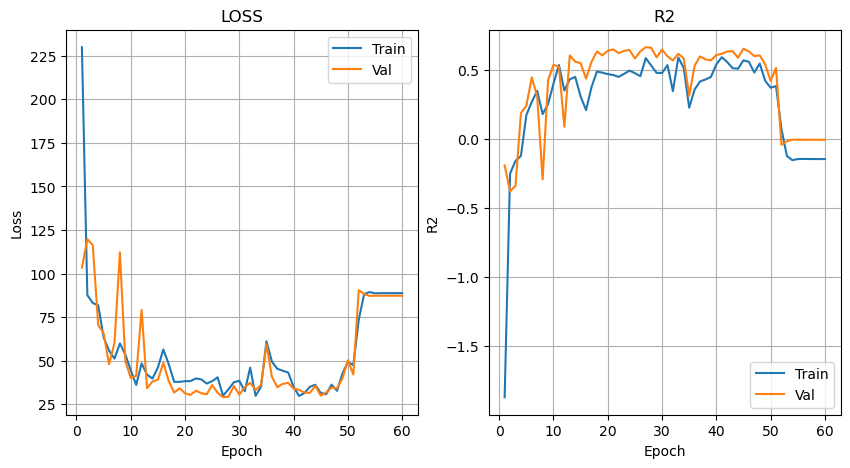

In [109]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

THRESHOLD=60

fg, axes=plt.subplots(1,2, figsize=(10,5))
axes[0].plot(range(1, THRESHOLD+1), loss_list[0][:THRESHOLD], label='Train')
axes[0].plot(range(1, THRESHOLD+1), loss_list[1][:THRESHOLD], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel('Loss')
axes[0].set_title('LOSS')

axes[1].plot(range(1, THRESHOLD+1), r2_list[0][:THRESHOLD], label='Train')
axes[1].plot(range(1, THRESHOLD+1), r2_list[1][:THRESHOLD], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel('R2')
axes[1].set_title('R2')
plt.show()